In [53]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as patches
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from demo_mappings import (criteria_mapping, label_mapping, occupation_mapping,
                           region_centers)
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from matplotlib.cm import RdYlBu_r
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.lines import Line2D
from scipy import stats

In [54]:
data = pd.read_csv("../../data/processed/data_encoded.csv", sep=",", encoding="ISO-8859-1")
raw_data = pd.read_csv("../../data/processed/data.csv", sep=",", encoding="ISO-8859-1")

# Set style parameters with large default font sizes
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 24  # Increased base font size
plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = '#f5f5f5'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.labelsize'] = 26  # Increased axis label size
plt.rcParams['axes.titlesize'] = 32  # Increased title size
plt.rcParams['xtick.labelsize'] = 24  # Increased tick label size
plt.rcParams['ytick.labelsize'] = 24  # Increased tick label size
plt.rcParams['legend.fontsize'] = 24  # Increased legend font size


def save_figure(save_path, format='pdf'):
    # Ensure format is valid
    if format.lower() not in ['pdf', 'png']:
        raise ValueError("Format must be either 'pdf' or 'png'")
    
    # Save the figure
    plt.savefig(f"../../figures/{save_path}.{format}", format=format.lower(), bbox_inches='tight', dpi=300)
    plt.close()

In [55]:
public_data = raw_data.drop(columns=['Unnamed: 0', 'gender'])
public_data['origin_region'] = [value[0] for value in public_data['origin_region'].str.split(':')]
public_data['work_region'] = [value[0] for value in public_data['work_region'].str.split(':')]
public_data['primary_area'] = public_data['primary_area'].str.replace('?', '', regex=False)
public_data.drop(columns=['other_criteria', 'comments'], inplace=True)

In [56]:
public_data.to_csv("../../data/processed/public_data.csv", index=False)
public_data

,career_stage,primary_area,origin_region,work_region,llm_intelligence,llm_intelligence_future,agreement,supp_research_area,occupation,criteria,lacking_criteria,entity_intelligence,intelligence_tests,research_goals
0,"Research student (PhD, MPhil)",Other,Europe,Europe,Disagree,"No, I disagree",More would agree than disagree,['Comp. Ling.'],"['Academia', 'Industry']","['Perception', 'Knowledge acq.', 'Reasoning', ...","['Perception', 'Knowledge acq.', 'Planning']","['Human', 'Ants', 'Amoebas']",['SAT/MSAT'],[]
1,Postdoc,Natural Language Processing,Europe,Europe,Disagree,"No, I disagree",Unsure,"['AI', 'CSS', 'ML', 'Psychology']","['Academia', 'Government/non-profit']","['Perception', 'Knowledge acq.', 'Problem solv...","['Perception', 'Reasoning', 'Adaptability', 'G...","['Human', 'Cats', 'Ants']",['I do not believe that we currently have such...,"['Practically Useful', 'Adding to the knowledg..."
2,Senior (faculty or industry),Natural Language Processing,Europe,Europe,Disagree,"No, I disagree",More would disagree than agree,"['AI', 'Comp. Ling.', 'CSS', 'ML', 'Psychology']",['Academia'],"['Env. interaction', 'Perception', 'Knowledge ...","['Embodiment', 'Knowledge acq.', 'Reasoning', ...","['Human', 'Cats', 'Ants']",['I do not believe that we currently have such...,"['Practically Useful', 'Adding to the knowledg..."
3,Senior (faculty or industry),Machine Learning,Europe,Europe,Disagree,"No, I disagree",Unsure,[],['Academia'],"['Knowledge acq.', 'Reasoning', 'Adaptability'...","['Knowledge acq.', 'Reasoning', 'Adaptability'...","['Human', 'Cats', 'Ants']",['IQ tests'],['Practically Useful']
4,Junior (faculty or industry),Machine Learning,Europe,Europe,Agree,NaN,More would agree than disagree,['Other'],['Academia'],"['Knowledge acq.', 'Reasoning', 'Planning', 'A...","['Env. interaction', 'Planning', 'Adaptability']","['Human', 'Cats', 'Ants', 'Autonomous robotic ...","['IQ tests', 'Generalization tests']","[""Creating technology that qualifies for my no..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,Junior (faculty or industry),Natural Language Processing,Europe,Europe,Agree,"Yes, I agree",Unsure,[],['Academia'],"['Knowledge acq.', 'Problem solving', 'Goal Ac...","['Env. interaction', 'Embodiment', 'Perception...","['Human', 'Cats']",['I do not believe that we currently have such...,"['Practically Useful', 'Adding to the knowledg..."
299,Postdoc,"Psychology (cognitive, developmental)",Europe,Europe,Disagree,"Yes, I agree",More would agree than disagree,"['CSS', 'CogSci']",['Academia'],"['Perception', 'Knowledge acq.', 'Problem solv...","['Env. interaction', 'Embodiment', 'Reasoning'...","['Human', 'Cats']","['preference ranking', 'IQ tests', 'Generaliza...",['Adding to the knowledge/scientific understan...
300,Senior (faculty or industry),Natural Language Processing,Europe,Europe,Agree,"Yes, I agree",More would agree than disagree,"['AI', 'Comp. Ling.', 'ML', 'Psycholinguistics']",['Academia'],"['Env. interaction', 'Perception', 'Problem so...","['Embodiment', 'Perception', 'Reasoning', 'Gen...","['Human', 'Cats', 'LLM-based chatbot', 'LLM-ba...",['I do not believe that we currently have such...,"[""Creating technology that qualifies for my no..."
301,Senior (faculty or industry),Natural Language Processing,Europe,America,Strongly disagree,NaN,More would agree than disagree,"['Comp. Ling.', 'CogSci', 'Other']",['Government/non-profit'],"['Perception', 'Knowledge acq.', 'Problem solv...","['Perception', 'Knowledge acq.', 'Goal Ach.', ...","['Human', 'Cats']",['Generalization tests'],"['Practically Useful', 'Adding to the knowledg..."


## Demographic plots

In [57]:
def plot_area_by_career_stage(data, save_path=None, format='pdf'):
    """
    Create a stacked bar plot showing distribution of research areas by career stage.
    """
    # Drop rows where career_stage is 'Other'
    data['career_stage'] = data['career_stage'].str.replace(r'\(.*?\)', '', regex=True).str.strip()
    career_order = ['Other student', 'Research student', 'Postdoc', 'Junior', 'Senior']
    
    # Create cross-tabulation of research areas and career stages
    stacked_data = pd.crosstab(data['primary_area'], data['career_stage'])
    
    # Sort the data by total counts
    stacked_data = stacked_data[career_order]
    stacked_data = stacked_data.loc[stacked_data.sum(axis=1).sort_values(ascending=False).index]

    # Create shortened labels
    shortened_labels = [label_mapping.get(area, area) for area in stacked_data.index]

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))  # Increased figure size

    # Create stacked bars
    bottom = np.zeros(len(stacked_data))
    bars = []
    colors = plt.cm.GnBu(np.linspace(.2, .9, len(stacked_data.columns)))

    for i, col in enumerate(stacked_data.columns):
        bars.append(ax.bar(range(len(stacked_data)), 
                        stacked_data[col],
                        bottom=bottom,
                        width=0.6,
                        alpha=0.8,
                        label=col,
                        color=colors[i]))
        bottom += stacked_data[col]

    # Customize the plot with larger font sizes
    ax.set_xticks(range(len(shortened_labels)))
    ax.set_xticklabels(shortened_labels, ha='right', rotation=45, fontsize=24)
    #ax.set_xlabel('Research Area', fontsize=28)
    #ax.set_ylabel('Respondents', fontsize=28)
    #ax.set_title('Distribution of Research Areas by Career Stage', fontsize=32, pad=10)

    # Add legend with larger font size
    ax.legend(loc='upper right', bbox_to_anchor=(0.98, 0.98), 
             title='Career Stage', fontsize=26, title_fontsize=28)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    if save_path:
        save_figure(save_path, format)
    else:
        plt.show()

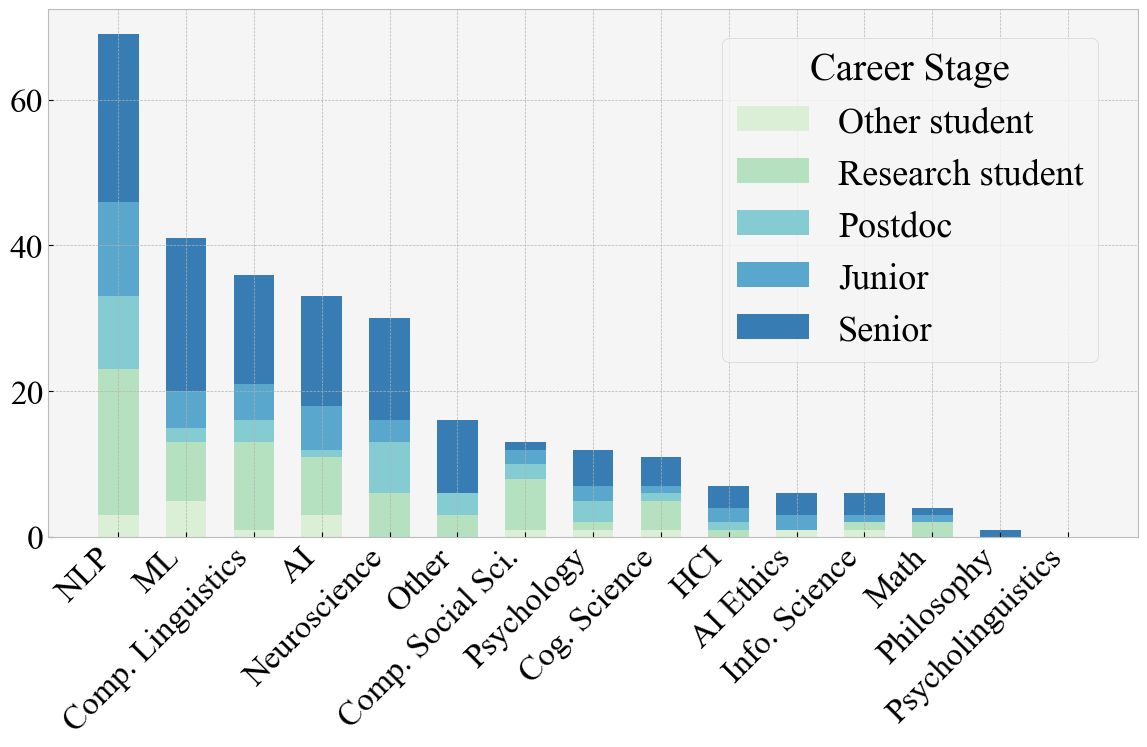

In [58]:
plot_area_by_career_stage(data, save_path=None, format="pdf")

# World Map

In [59]:
def plot_world_map(data, region_type="origin_region", save_path=None, format='pdf'):
    """ 
    Create a world map showing distribution of research areas by career stage.
    """
    # Get value counts of regions from origin_region
    region_counts = data[region_type].value_counts()

    # Create figure and axes with projection
    plt.figure(figsize=(18, 12))  # Increased figure size
    ax = plt.axes(projection=ccrs.Robinson())

    # Add map features
    ax.add_feature(cfeature.LAND, facecolor='white', alpha=0.5)
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':')

    # Set map extent to show the whole world
    ax.set_global()

    # Add circles for each region
    max_count = region_counts.max()
    for region, center in region_centers.items():
        if region in region_counts.index:
            count = region_counts[region]
            # Scale circle size based on count
            size = 7000 * np.sqrt(count / max_count)  # Increased base circle size
            
            # Create color based on count
            color = plt.cm.Blues(0.3 + 0.7 * (count / max_count))
            
            ax.scatter(center[1], center[0], 
                    s=size,
                    color=color,
                    alpha=0.6,
                    transform=ccrs.PlateCarree(),
                    label=f'{region}')  # Added count to label
    

    europe_count, america_count, asia_count, africa_count, oceania_count = 0, 0, 0, 0, 0
    dict(data[region_type].value_counts())
    for region, count in dict(data[region_type].value_counts()).items():
        if "Europe" in region:
            europe_count += count
        elif "America" in region:
            america_count += count
        elif "Asia" in region:
            asia_count += count
        elif "Africa" in region:
            africa_count += count
        elif "Oceania" in region:
            oceania_count += count

    counts = {
        "Europe": round(europe_count / 291, 2) * 100,
        "America": round(america_count / 291, 2) * 100,
        "Asia": round(asia_count / 291, 2) * 100,
        "Africa": round(africa_count / 291, 2) * 100,
        "Oceania": round(oceania_count / 291, 2) * 100
    }

    eu_patch = patches.Patch(label=f"Europe: {round(counts['Europe'], 2)}%", color=plt.cm.Blues(0.3 + 0.7 * (1 / 1)))
    am_patch = patches.Patch(label=f"America: {counts['America']}%", color=plt.cm.Blues(0.3 + 0.7 * (1 / 3)))
    as_patch = patches.Patch(label=f"Asia: {round(counts['Asia'], 2)}%", color=plt.cm.Blues(0.3 + 0.7 * (1 / 10)))
    af_patch = patches.Patch(label=f"Africa: {counts['Africa']}%", color=plt.cm.Blues(0.3 + 0.7 * (1 / 20)))
    oc_patch = patches.Patch(label=f"Oceania: {counts['Oceania']}%", color=plt.cm.Blues(0.3 + 0.7 * (1 / 30)))
    plt.legend(handles=[eu_patch, am_patch, as_patch, af_patch, oc_patch], loc='upper right', fontsize=24)

    # Add title with larger font size
    plt.title('Geographic Distribution of Respondents', 
            pad=5,  # Increased padding
            fontsize=38)  # Increased title font size

    # Adjust layout
    plt.tight_layout()

    if save_path:
        save_figure(save_path, format)
    else:
        plt.show()

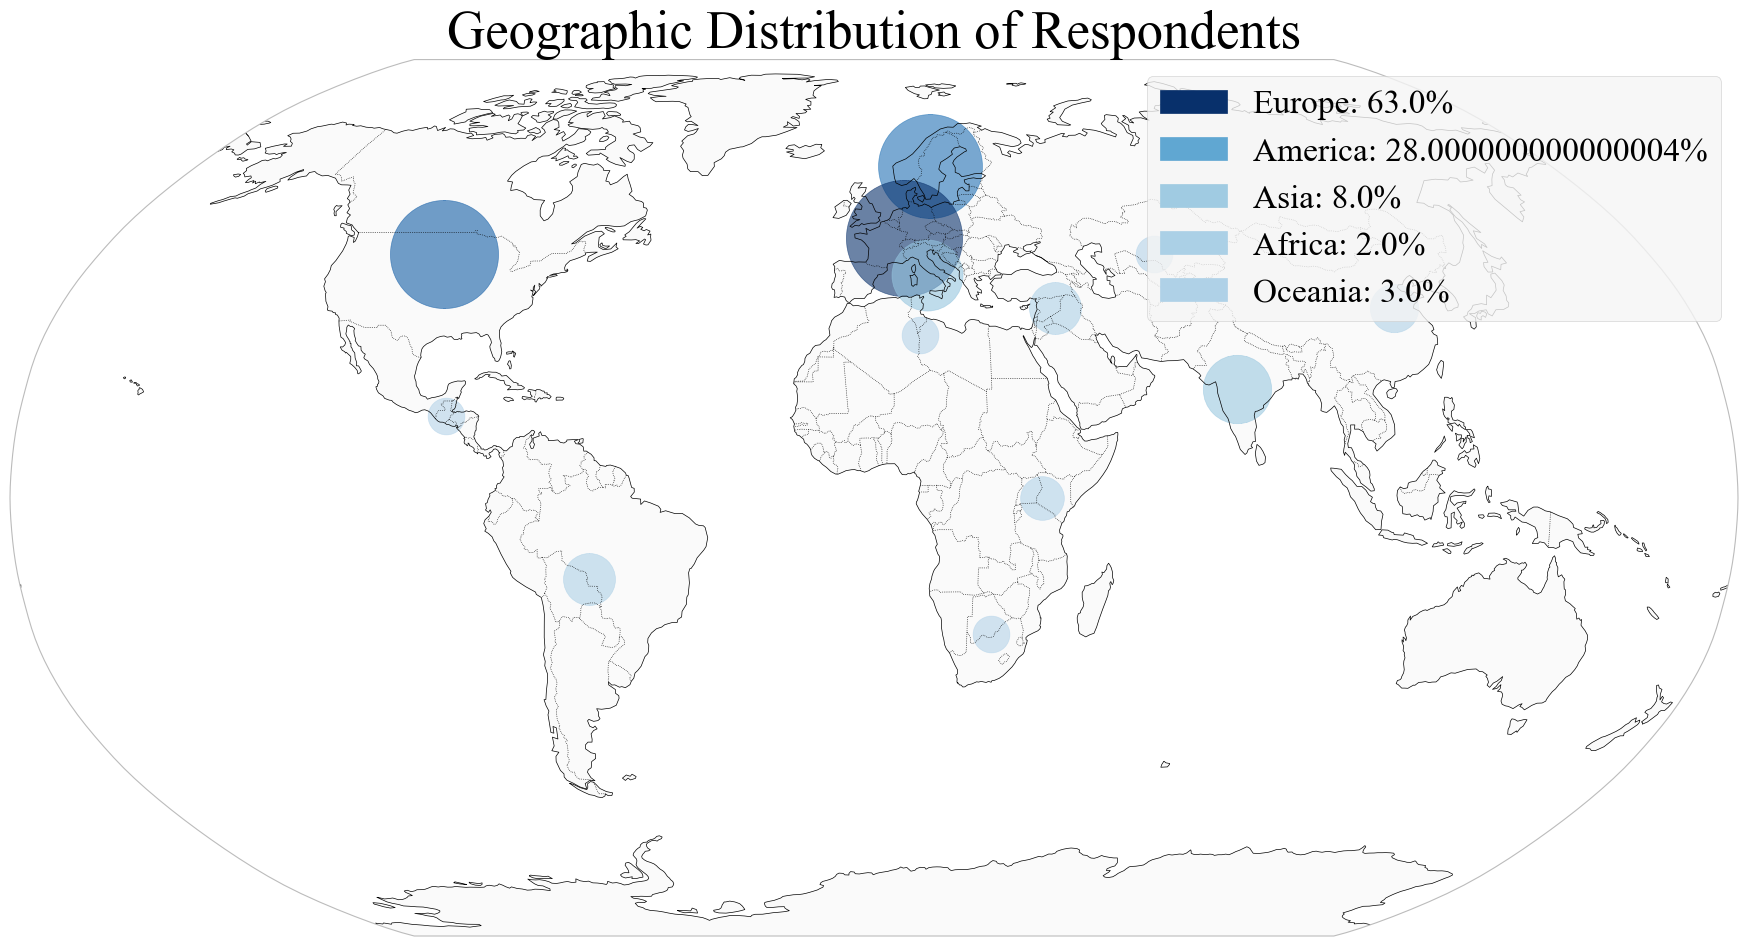

In [60]:
plot_world_map(data, region_type="work_region", save_path=None, format="pdf")

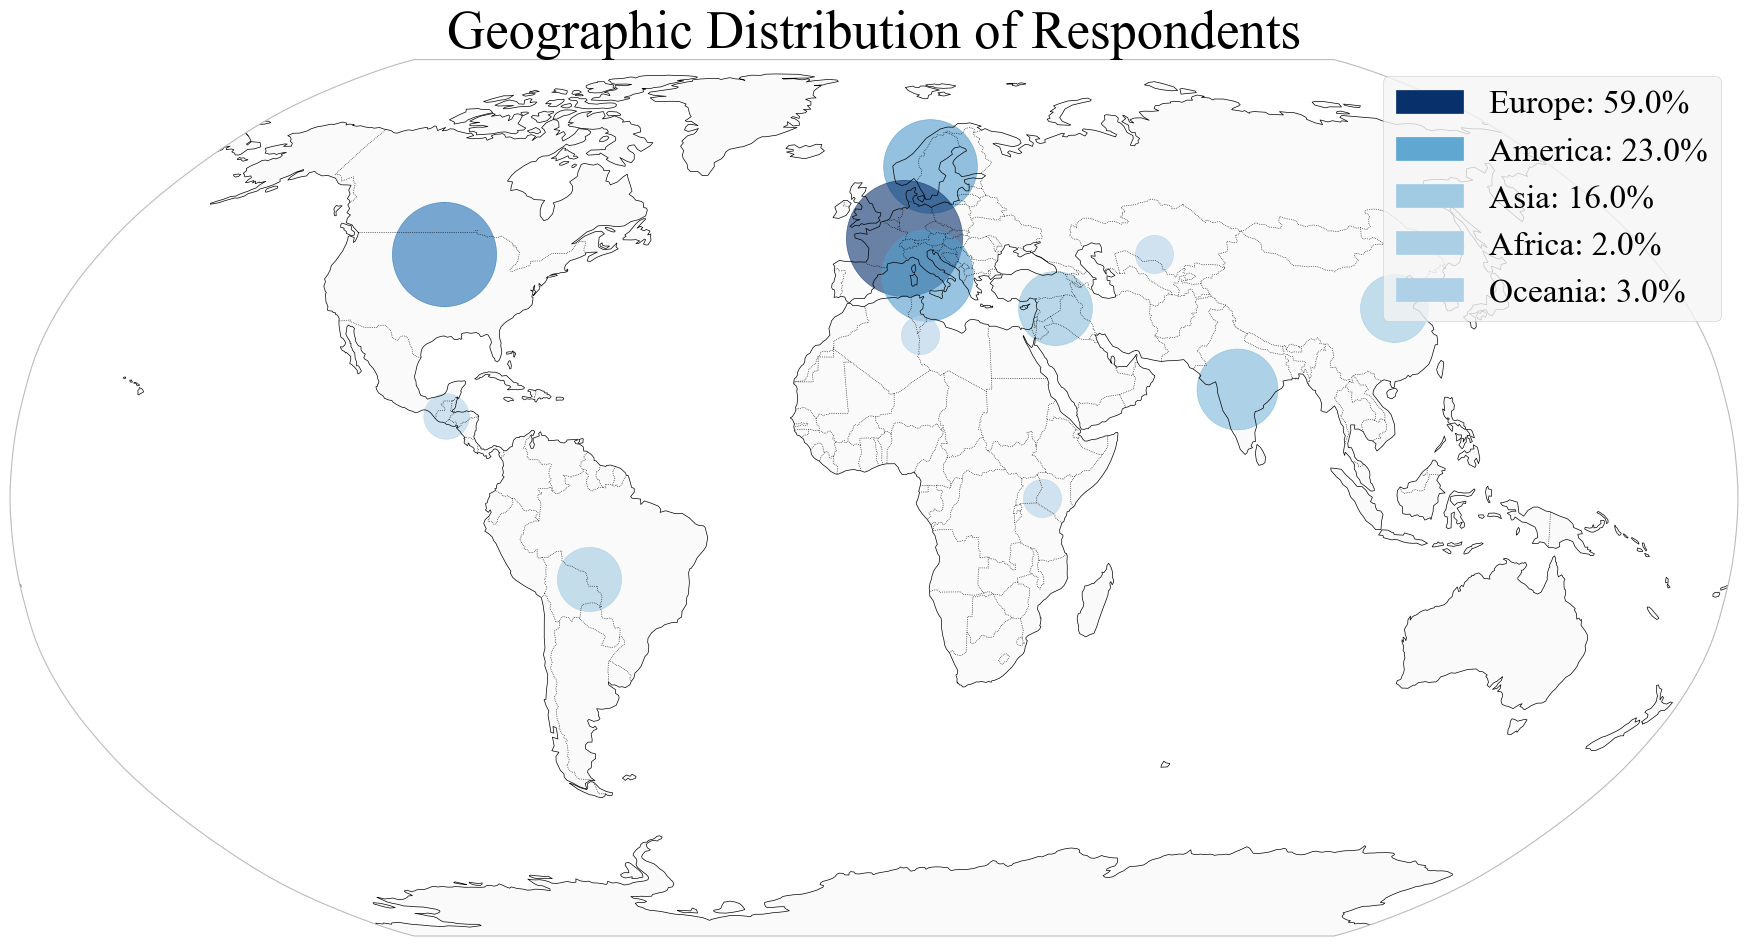

In [61]:
plot_world_map(data, region_type="origin_region", save_path=None, format="pdf")

## Intelligence Criteria by Occupation

In [62]:
def plot_criteria_by_occupation(data, save_path=None, format='pdf'):
    """
    Create a stacked bar plot showing distribution of research areas by career stage.
    """
    # Get occupation columns (excluding Undisclosed)
    occupation_columns = [col for col in data.columns 
                        if col.startswith('occ_') and 'Undisclosed' not in col]

    # Calculate percentages for each criterion and occupation
    percentages_data = []
    occupation_totals = {occ: data[occ].sum() for occ in occupation_columns}

    for criterion in criteria_mapping.keys():
        criterion_data = {'Criterion': criteria_mapping[criterion]}
        for occ in occupation_columns:
            total_in_occ = occupation_totals[occ]
            selected_both = data[(data[occ] == 1) & (data[criterion] == 1)].shape[0]
            percentage = (selected_both / total_in_occ * 100) if total_in_occ > 0 else 0
            criterion_data[occ] = percentage
        percentages_data.append(criterion_data)

    # Create DataFrame
    df_percentages = pd.DataFrame(percentages_data)

    # Create the plot with increased figure size
    fig, ax = plt.subplots(figsize=(10, 14))  # Increased height for better readability

    # Set bar positions
    bar_height = 0.25
    y = np.arange(len(criteria_mapping))
    colors = plt.cm.GnBu(np.linspace(0.4, 0.8, len(occupation_columns)))

    # Create bars for each occupation
    for i, occ in enumerate(occupation_columns):
        occ_label = f"{occ.replace('occ_', '').replace('_', '/')}"
        position = y + i * bar_height - bar_height
        ax.barh(position,
                df_percentages[occ],
                height=bar_height,
                label=occ_label,
                color=colors[i],
                alpha=0.8)

    # Customize the plot with larger font sizes
    ax.set_yticks(y)
    ax.set_yticklabels(df_percentages['Criterion'],
                    fontsize=26)  # Increased y-axis label size
    #ax.set_xlabel('Percentage of Respondents in Group', fontsize=28)  # Increased x-axis label size
    #ax.set_title('Selection of Intelligence Criteria by Occupation', 
    #            fontsize=32,  # Increased title size
    #            pad=10)  # Added more padding to title

    # Add legend with larger font size
    ax.legend(bbox_to_anchor=(.42, 1),
            loc='upper left',
            fontsize=22)  # Increased legend font size

    # Set x-axis to percentages and add grid
    ax.set_xlim(0, 100)
    ax.xaxis.grid(True, linestyle='--', alpha=0.7)

    # Increase tick label sizes
    ax.tick_params(axis='both', labelsize=22)  # Increased tick label size

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    if save_path:
        save_figure(save_path, format)
    else:
        plt.show()

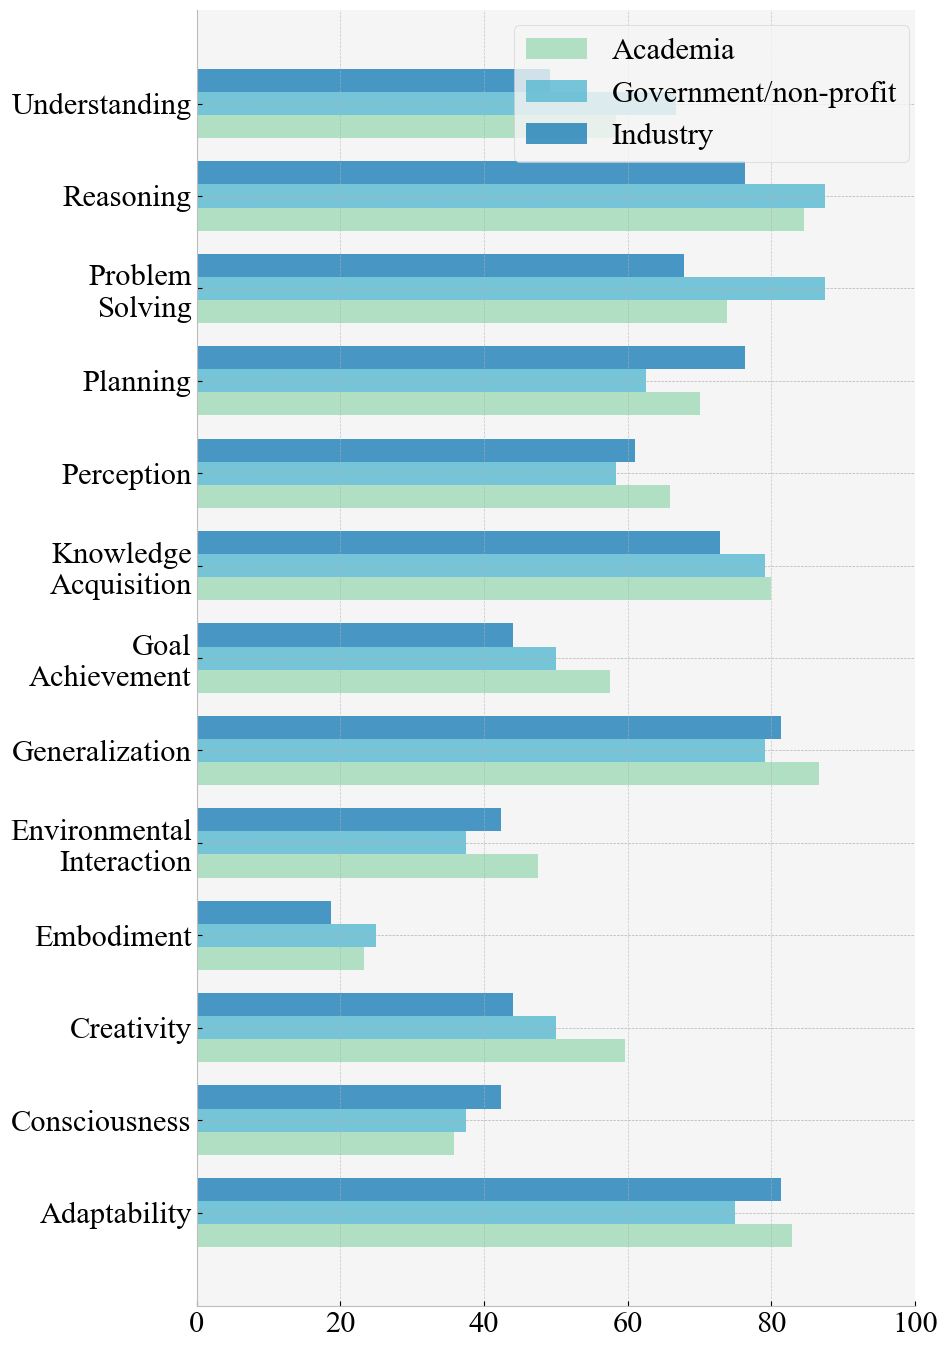

In [63]:
plot_criteria_by_occupation(data, save_path=None, format="pdf")

# Intelligence Criteria by Career Stage

In [64]:
def plot_criteria_by_career_stage(data, save_path=None, format='pdf'):
    """
    Create a stacked bar plot showing distribution of research areas by career stage.
    """
    # Define the career stages we want to include
    selected_stages = ['Research student (PhD, MPhil)', 'Postdoc',
                    'Senior (faculty or industry)', 'Junior (faculty or industry)']

    # Get career stage counts for selected stages
    career_stage_totals = data['career_stage'].value_counts()[selected_stages]

    # Calculate percentages for each criterion and career stage
    percentages_data = []
    for criterion in criteria_mapping.keys():
        criterion_data = {'Criterion': criteria_mapping[criterion]}
        for stage in selected_stages:
            total_in_stage = career_stage_totals[stage]
            selected_both = data[(data['career_stage'] == stage) & (data[criterion] == 1)].shape[0]
            percentage = (selected_both / total_in_stage * 100) if total_in_stage > 0 else 0
            criterion_data[stage] = percentage
        percentages_data.append(criterion_data)

    # Create DataFrame
    df_percentages = pd.DataFrame(percentages_data)

    # Create the plot with increased figure size
    fig, ax = plt.subplots(figsize=(10, 14))  # Increased height for better readability

    # Set bar positions
    bar_height = 0.2
    y = np.arange(len(criteria_mapping))
    colors = plt.cm.GnBu(np.linspace(0.4, 0.8, len(selected_stages)))

    # Create bars for each career stage
    for i, stage in enumerate(selected_stages):
        stage_label = f"{stage.replace(' (faculty or industry)', '')} (n={career_stage_totals[stage]})"
        position = y + i * bar_height - (bar_height * len(selected_stages)/2) + bar_height/2
        ax.barh(position,
            df_percentages[stage],
            height=bar_height,
            label=stage_label,
            color=colors[i],
            alpha=0.8)

    # Customize the plot with larger font sizes
    ax.set_yticks(y)
    ax.set_yticklabels(df_percentages['Criterion'],
                    fontsize=24,  # Increased y-axis label size
                    ha='right')
    ax.set_xlabel('Percentage of Respondents in Group', fontsize=28)  # Increased x-axis label size
    ax.set_title('Selection of Intelligence Criteria by Career Stage', 
                fontsize=32,  # Increased title size
                pad=10)  # Added more padding to title

    # Add legend with larger font size
    ax.legend(bbox_to_anchor=(0.29, 1),
            loc='upper left',
            fontsize=18)  # Increased legend font size

    # Set x-axis to percentages and add grid
    ax.set_xlim(0, 100)
    ax.xaxis.grid(True, linestyle='--', alpha=0.7)

    # Increase tick label sizes
    ax.tick_params(axis='both', labelsize=24)  # Increased tick label size

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    if save_path:
        save_figure(save_path, format)
    else:
        plt.show()

In [65]:
plot_criteria_by_career_stage(data, save_path=None, format="pdf")

KeyError: "['Research student (PhD, MPhil)', 'Senior (faculty or industry)', 'Junior (faculty or industry)'] not in index"

# Intelligence Beliefs - Sankey Diagram

In [67]:
def plot_sankey_diagram(data, save_path=None, format='pdf', career_id=None, research_id=None):
    """
    Create a Sankey diagram showing the flow of intelligence criteria by career stage and occupation.
    """

    if career_id != None:
        data = data[data['career_stage'] == career_id]
    if research_id != None:
        data = data[data['primary_area'] == research_id]

    # Create flow data
    flow_df = data.groupby(['llm_intelligence', 'llm_intelligence_future']).size().reset_index(name='value')

    # Define node order (top to bottom)
    current_order = ['Strongly agree', 'Agree', 'Disagree', 'Strongly disagree']
    future_order = ['Yes, I strongly agree', 'Yes, I agree', 'No, I disagree', 'No, I strongly disagree']

    # Calculate node positions
    def calculate_node_positions(values, order, x_pos):
        total = sum(values)
        positions = {}
        current_pos = 0
        for node in order:
            value = values.get(node, 0)
            height = value / total
            positions[node] = (x_pos, current_pos + height/2, height)
            current_pos += height
        return positions

    # Get node values
    current_values = data['llm_intelligence'].value_counts()
    future_values = data['llm_intelligence_future'].value_counts()

    # Calculate positions
    left_nodes = calculate_node_positions(current_values, current_order, 0)
    right_nodes = calculate_node_positions(future_values, future_order, 1)

    # Create the plot with increased figure size
    fig, ax = plt.subplots(figsize=(14, 10))  # Increased figure size

    # Use GnBu colormap
    colors = plt.cm.GnBu(np.linspace(0.3, 0.9, 4))

    # Draw the nodes (boxes) with increased font size
    def draw_node(pos, height, label, color, width=0.2):
        rect = patches.Rectangle((pos[0], pos[1]-height/2), width, height, 
                            facecolor=color, alpha=0.7, edgecolor='none')
        ax.add_patch(rect)
        ax.text(pos[0]+width/2, pos[1], 
            fr'{height*100:.1f}%', 
            va='center', ha='center', 
            fontsize=32)  # Increased font size for node labels

    def draw_flow(start, end, value, total_flow, color):
        # Calculate proportional heights on both sides
        start_height = (value/total_flow) * 0.2
        end_height = (value/total_flow) * 1
        
        # Calculate y-coordinates for flow
        start_y = start[1]
        end_y = end[1]
        
        # Calculate top and bottom points for start and end
        start_top = start_y + start_height/2
        start_bottom = start_y - start_height/2
        end_top = end_y + end_height/2
        end_bottom = end_y - end_height/2
        
        # Create the curved path
        verts = [
            (start[0]+0.2, start_top),
            (start[0]+0.4, start_top),
            (end[0]-0.4, end_top),
            (end[0], end_top),
            (end[0], end_bottom),
            (end[0]-0.4, end_bottom),
            (start[0]+0.4, start_bottom),
            (start[0]+0.2, start_bottom),
            (start[0]+0.2, start_top),
        ]
        
        codes = [
            mpath.Path.MOVETO,
            mpath.Path.CURVE4,
            mpath.Path.CURVE4,
            mpath.Path.CURVE4,
            mpath.Path.LINETO,
            mpath.Path.CURVE4,
            mpath.Path.CURVE4,
            mpath.Path.CURVE4,
            mpath.Path.CLOSEPOLY,
        ]
        
        path = mpath.Path(verts, codes)
        patch = patches.PathPatch(path, facecolor=color, alpha=0.3, edgecolor='none')
        ax.add_patch(patch)

    # Draw nodes and create legend elements with increased font sizes
    legend_elements = []
    for i, (node, (x, y, h)) in enumerate(left_nodes.items()):
        draw_node((x, y), h, node, colors[i])
        legend_elements.append(patches.Patch(facecolor=colors[i], alpha=0.7,
                                        label=node))
        
    for i, (node, (x, y, h)) in enumerate(right_nodes.items()):
        draw_node((x, y), h, node, colors[i])

    # Draw flows
    total_flow = flow_df['value'].sum()
    for _, row in flow_df.iterrows():
        start = left_nodes[row['llm_intelligence']]
        end = right_nodes[row['llm_intelligence_future']]
        color = colors[current_order.index(row['llm_intelligence'])]
        draw_flow(start, end, row['value'], total_flow, color)

    # Add horizontal legend at the bottom with increased font size
    ax.legend(handles=legend_elements, 
            loc='center', 
            bbox_to_anchor=(0.53, 0.02),
            ncol=2,
            frameon=True,
            columnspacing=1.0,
            fontsize=25)  # Increased legend font size

    # Customize plot with larger font sizes
    ax.set_xlim(-0.2, 1.3)
    ax.set_ylim(-0.1, 1.1)
    plt.axis('off')
    #plt.title('Belief Transition:\nCurrent intelligence to future intelligence',
    #         fontsize=32,  # Increased title font size
    #         pad=5)  # Added more padding

    plt.tight_layout()

    if save_path:
        save_figure(save_path, format)
    else:
        plt.show()

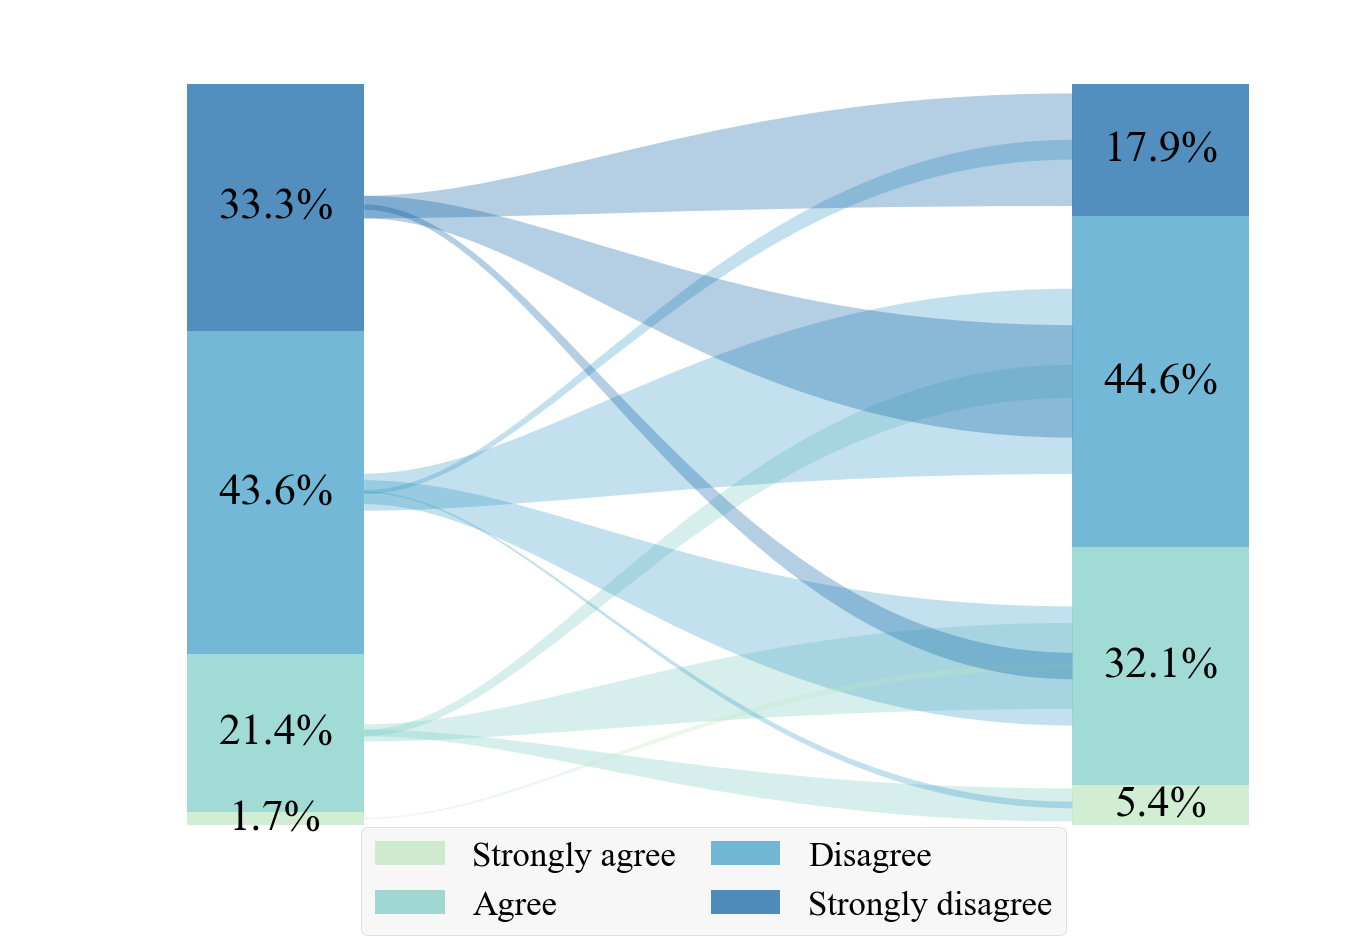

In [68]:
plot_sankey_diagram(data, save_path=None, format="pdf", career_id='Senior')

In [52]:
plot_sankey_diagram(data, save_path=None, format="pdf", career_id='Senior')

NameError: name 'plot_sankey_diagram' is not defined

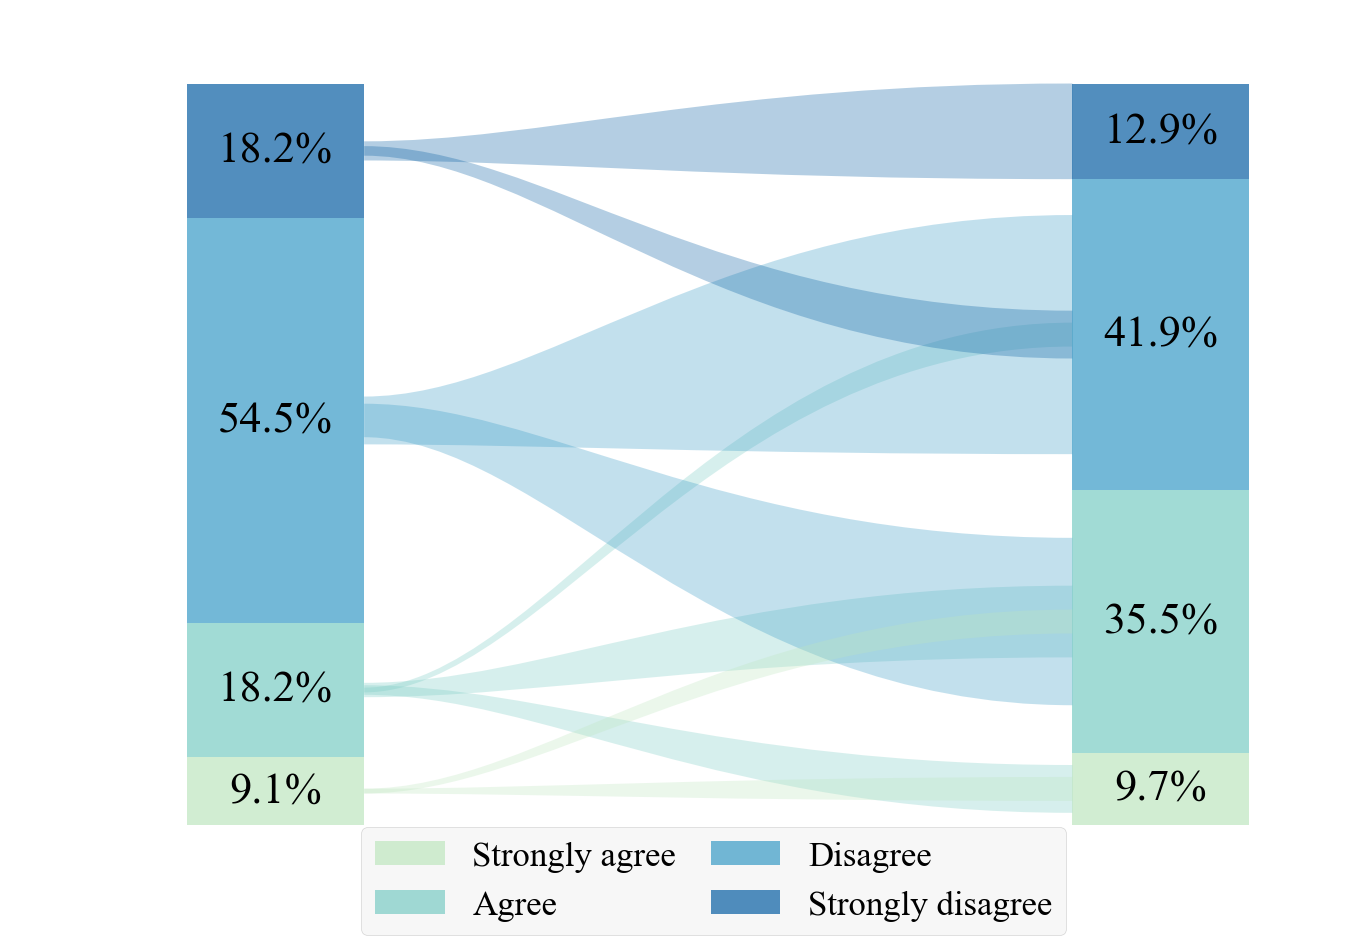

In [142]:
plot_sankey_diagram(data, save_path=None, format="pdf", research_id='Artificial Intelligence')

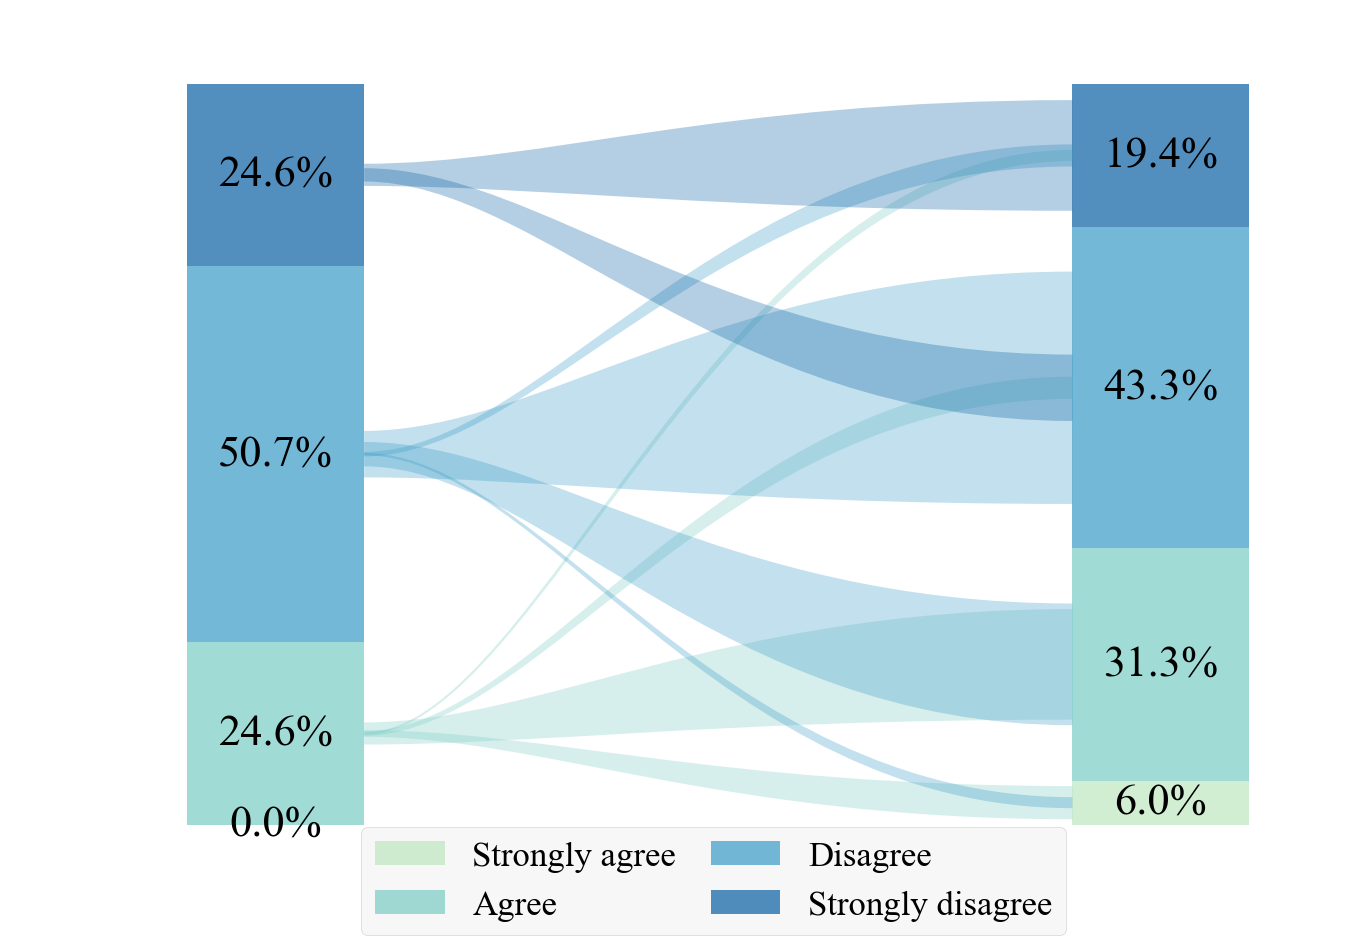

In [143]:
plot_sankey_diagram(data, save_path=None, format="pdf", research_id='Natural Language Processing')

# Criteria Correlation Graph

In [26]:
def plot_correlation_graph(data, save_path=None, format='pdf'):
    """
    Create a correlation graph showing the correlation between intelligence criteria and career stage.
    """
    # Get criteria columns
    criteria_cols = [col for col in data.columns if col.startswith('crit_')]
    criteria_data = data[criteria_cols]
    # Calculate correlation matrix
    corr_matrix = criteria_data.corr()

    # Calculate p-values using scipy's pearsonr
    p_values = np.zeros_like(corr_matrix.values)
    for i in range(len(criteria_cols)):
        for j in range(len(criteria_cols)):
            if i != j:
                _, p_value = stats.pearsonr(criteria_data[criteria_cols[i]], 
                                        criteria_data[criteria_cols[j]])
                p_values[i,j] = p_value

    # Create network graph
    G = nx.Graph()

    # Add nodes with their total responses
    total_responses = criteria_data.sum()
    for col in criteria_cols:
        node_name = col.replace('crit_', '')
        responses = total_responses[col]
        G.add_node(node_name, responses=responses)

    # Add edges (only for correlations above a threshold)
    threshold = 0.1
    for i in range(len(criteria_cols)):
        for j in range(i+1, len(criteria_cols)):
            correlation = corr_matrix.iloc[i, j]
            if abs(correlation) > threshold:
                G.add_edge(criteria_cols[i].replace('crit_', ''),
                        criteria_cols[j].replace('crit_', ''),
                        weight=correlation,
                        significant=(p_values[i,j] < 0.05))

    # Set up the plot with increased figure size
    plt.figure(figsize=(20, 20))  # Increased figure size
    main_ax = plt.gca()

    # Create circular layout
    pos = nx.circular_layout(G)

    # Calculate node sizes based on total responses
    node_responses = [G.nodes[node]['responses'] for node in G.nodes()]
    min_size = 1000  # Increased minimum node size
    max_size = 14000  # Increased maximum node size
    node_sizes = [min_size + (max_size - min_size) * (responses / max(node_responses))
                for responses in node_responses]

    # Create normalized response values for color mapping
    min_responses = min(node_responses)
    max_responses = max(node_responses)
    norm = Normalize(vmin=min_responses, vmax=max_responses)

    # Create blue color gradient and map node colors
    blues_cmap = LinearSegmentedColormap.from_list('blues', plt.cm.Blues(np.linspace(0.3, 0.7, 256)))
    node_colors = blues_cmap(norm(node_responses))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos,
                        node_color=node_colors,
                        node_size=node_sizes,
                        alpha=0.7)

    # Draw edges with width and color based on correlation strength
    edges = list(G.edges(data=True))
    weights = [edge[2]['weight'] for edge in edges]

    # Create color mapping based on actual correlation values
    min_corr = min(weights)
    max_corr = max(weights)
    normalized_weights = [(w - min_corr) / (max_corr - min_corr) for w in weights]
    edge_colors = [plt.cm.RdYlBu_r(0.2 + 0.8 * nw) for nw in normalized_weights]

    # Draw edges with varying colors and styles based on significance
    for (u, v, data), width, color in zip(edges, weights, edge_colors):
        style = 'solid' if data['significant'] else 'dashed'
        nx.draw_networkx_edges(G, pos,
                            edgelist=[(u, v)],
                            width=width*14,  # Increased edge width
                            edge_color=[color],
                            alpha=0.6,
                            style=style)

    # Add labels with total responses with increased font size
    labels = {node: f"{node}\n({int(G.nodes[node]['responses'])})"
            for node in G.nodes()}
    
    label_map = {"Env._interaction": "Environmental\nInteraction", "Problem_solving": "Problem\nSolving", "Goal_Ach.": "Goal\nAchievement", "Knowledge_acq.": "Knowledge\nAcquisition"}
    for l in label_map:
        n = labels[l].split("\n")[-1]
        labels[l] = f"{label_map[l]}\n{n}"

    nx.draw_networkx_labels(G, pos, labels, 
                          font_size=40,
                          font_weight='bold',
                          font_family='Times New Roman')
    #plt.title('Intelligence Criteria',
    #        pad=1, 
    #        fontsize=60,
    #        fontweight='bold') 
    plt.axis('off')

    plt.tight_layout()

    if save_path:
        save_figure(save_path, format)
    else:
        plt.show()

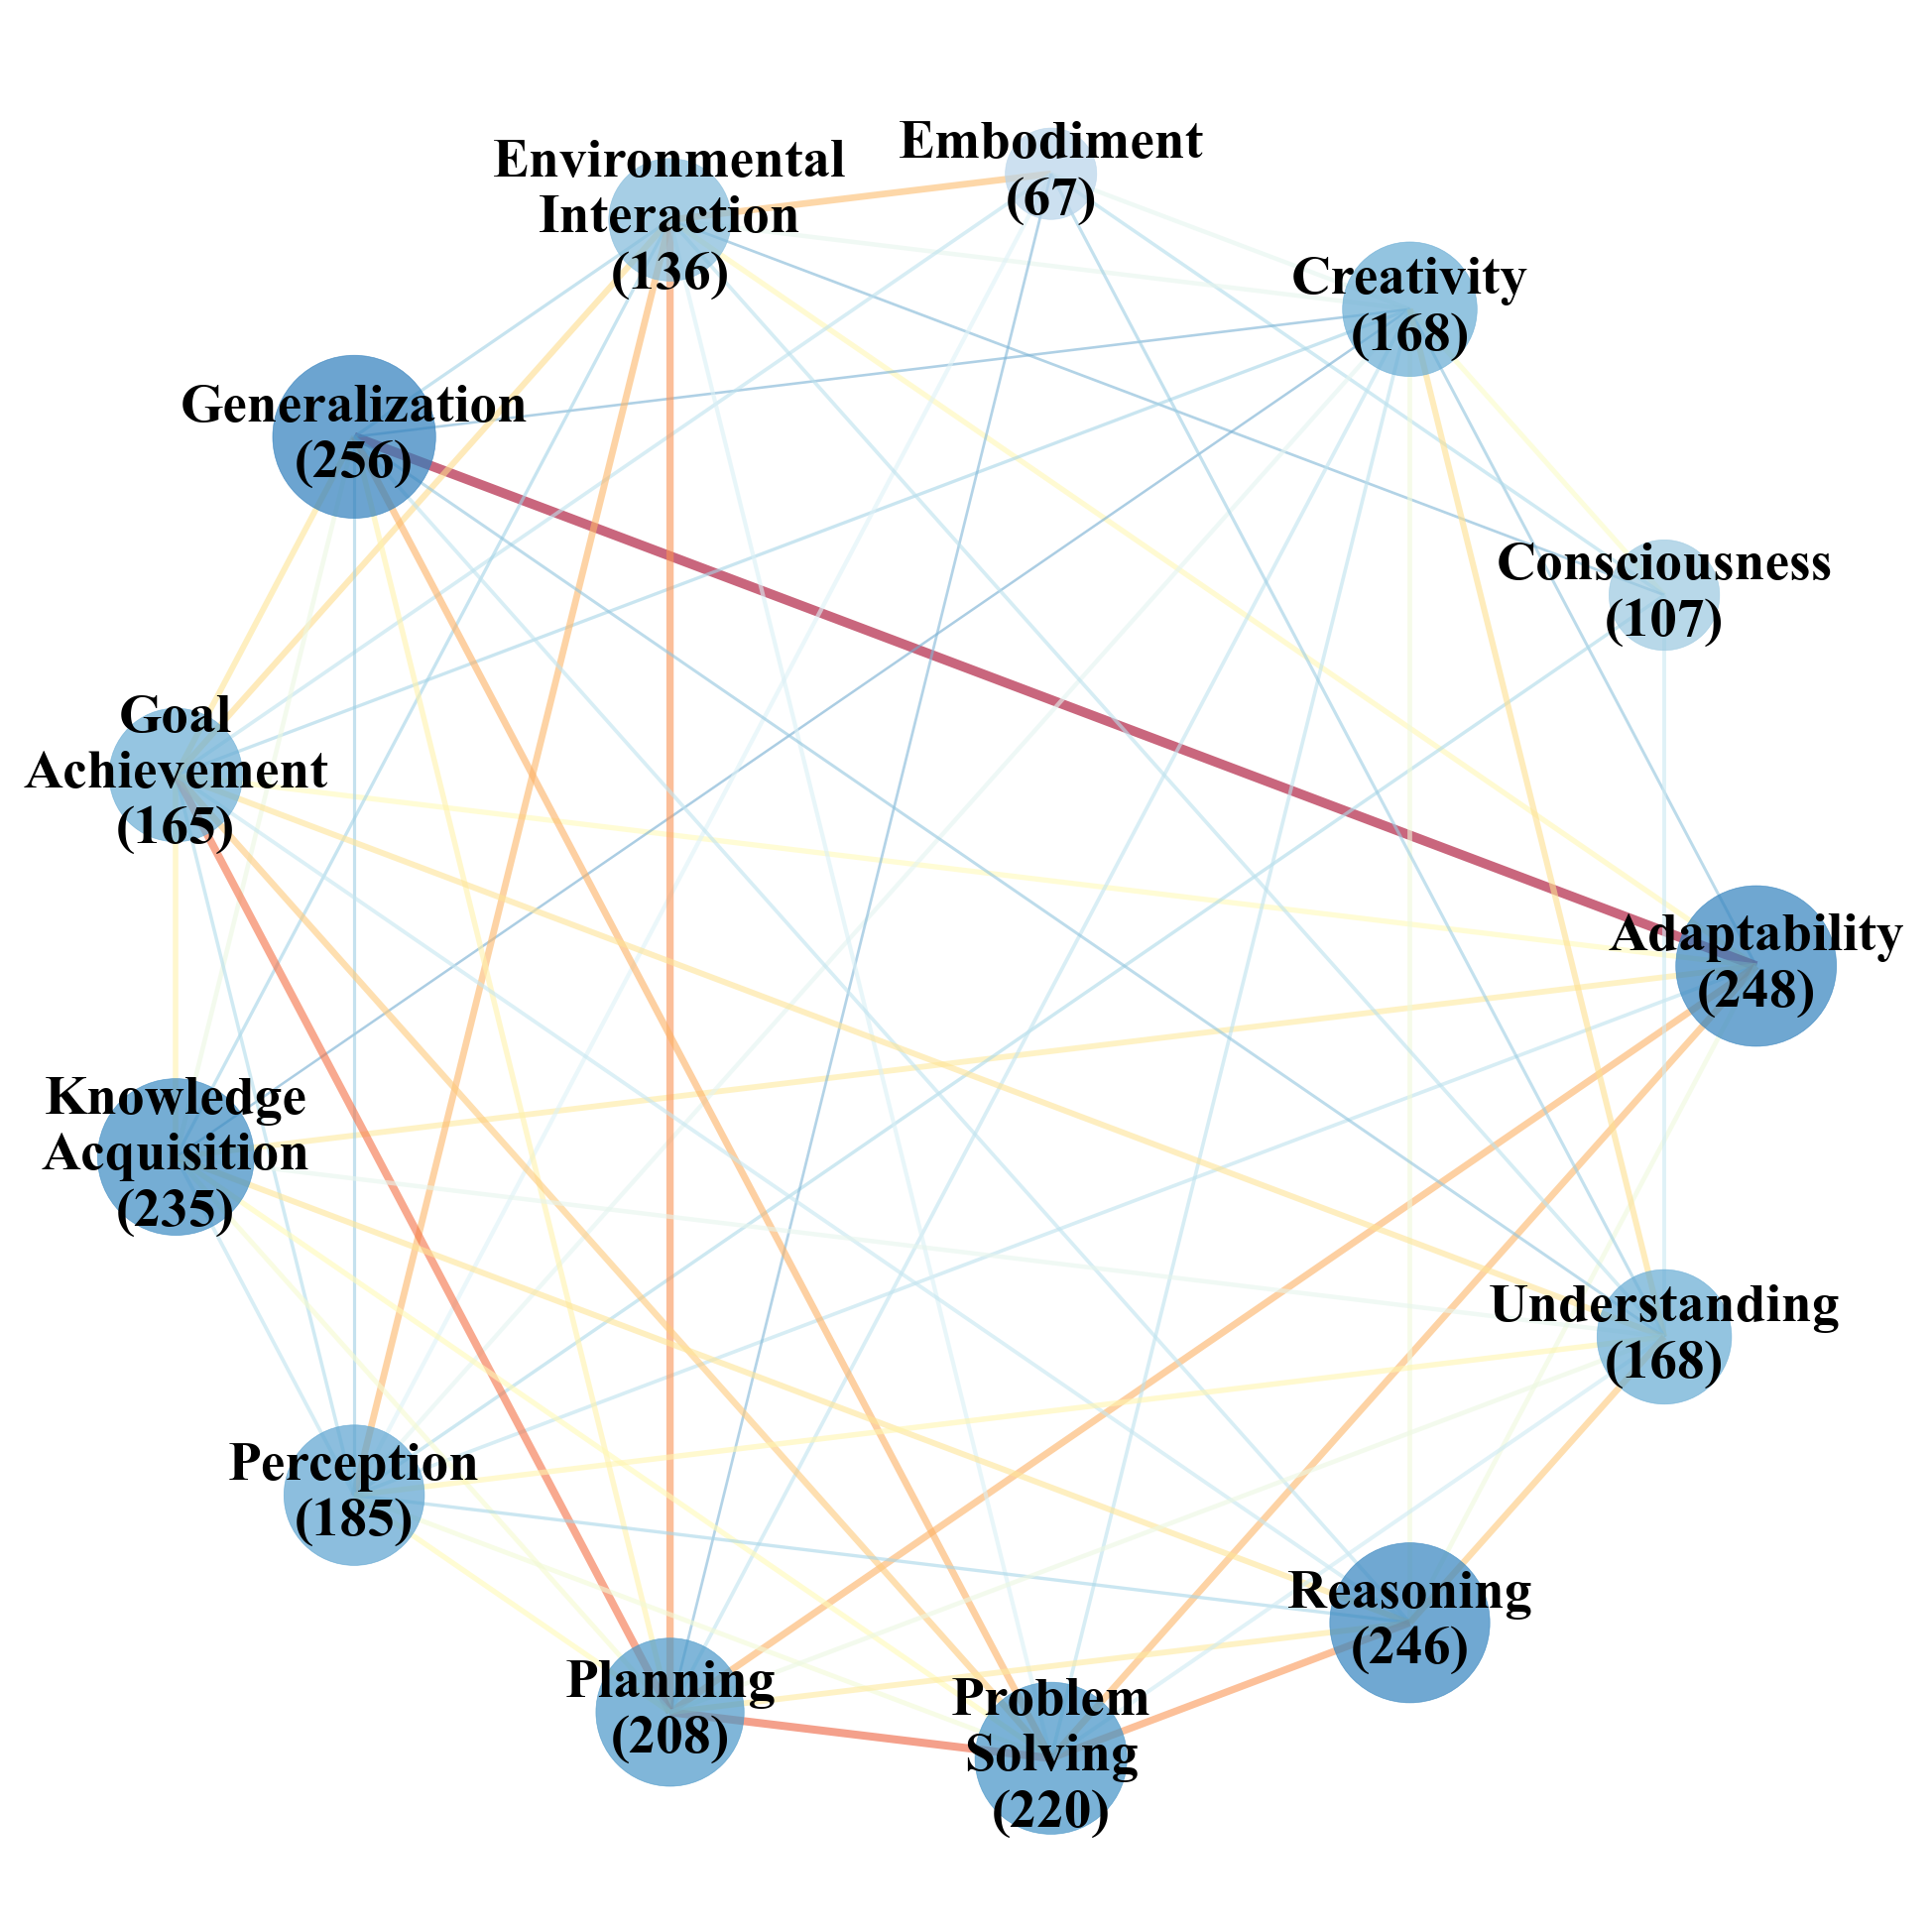

In [27]:
plot_correlation_graph(data, save_path=None, format="pdf")

In [28]:
#plot_world_map(data, region_type="origin_region", save_path="world_map_origin", format="pdf")
#plot_world_map(data, region_type="work_region", save_path="world_map_work", format="pdf")
#plot_sankey_diagram(data, save_path="sankey_diagram", format="pdf")
plot_correlation_graph(data, save_path="correlation_graph", format="pdf")

In [88]:
plot_area_by_career_stage(data, save_path="area_by_career_stage", format="pdf")
plot_criteria_by_occupation(data, save_path="criteria_by_occupation", format="pdf")

In [69]:
plot_sankey_diagram(data, save_path="sankey_diagram_nlp", format="pdf", research_id='Natural Language Processing')
plot_sankey_diagram(data, save_path="sankey_diagram_ai", format="pdf", research_id='Artificial Intelligence')
plot_sankey_diagram(data, save_path="sankey_diagram_senior", format="pdf", career_id='Senior')
plot_sankey_diagram(data, save_path="sankey_diagram_phd", format="pdf", career_id='Research student')

# Additional Questions

In [31]:
plot_world_map(data, region_type="origin_region", save_path="world_map_origin", format="pdf")
plot_world_map(data, region_type="work_region", save_path="world_map_work", format="pdf")
plot_sankey_diagram(data, save_path="sankey_diagram", format="pdf")
plot_correlation_graph(data, save_path="correlation_graph", format="pdf")

In [148]:
ent_columns = [col for col in data.columns 
                        if col.startswith('ent_') and 'Undisclosed' not in col]

ent_data = data[ent_columns].sum().sort_values(ascending=False)

In [149]:
ent_data.index = ent_data.index.str.split('_').map(lambda x: x[-2] + ' ' + x[-1] if x[-2] != 'ent' else x[-1])
ent_data = ent_data.reset_index()
ent_data.columns = ['Entity', 'Count']
print(ent_data)

              Entity  Count
0              Human    268
1               Cats    222
2               Ants    145
3  LLM-based chatbot     56
4   LLM-based agents     49
5            Amoebas     41
6    robotic systems     39
7     Narrow systems     33
8    Earlier chatbot     11
9               None      4


/var/folders/kb/bcbrv17s4xq_0vrbn5spf7kh0000gn/T/ipykernel_64976/2172498903.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ent_data.Entity, rotation=45, ha='right', fontsize=28)


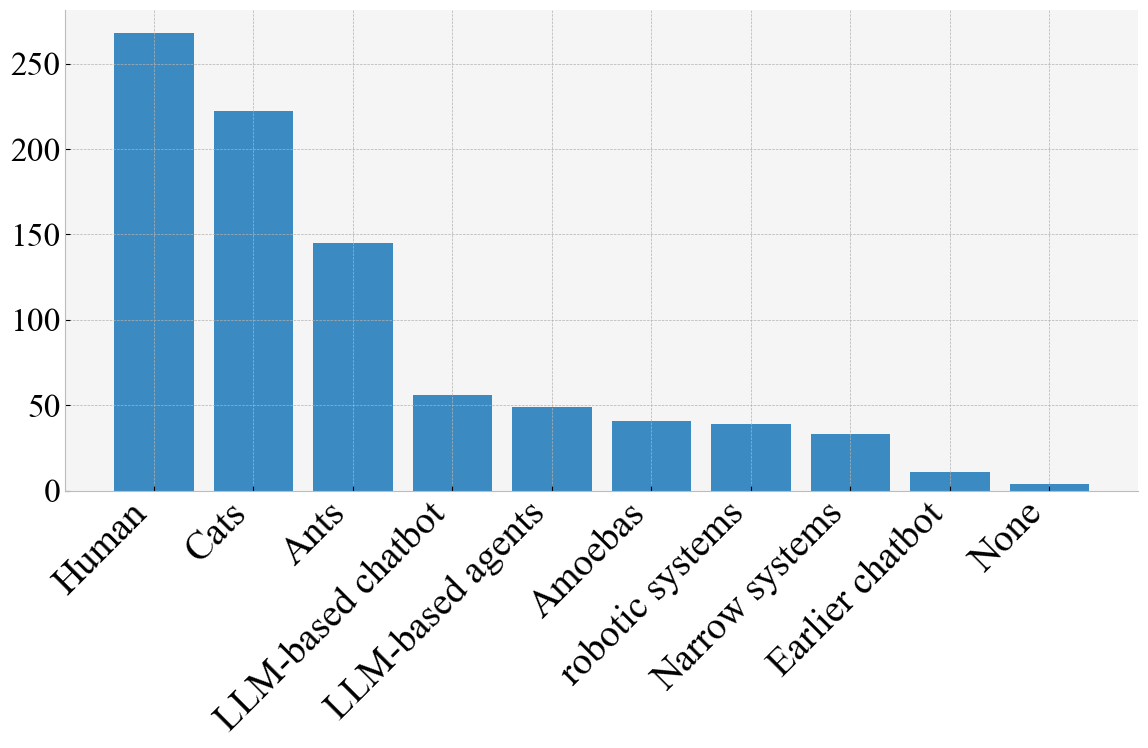

In [157]:
# Create the plot with increased figure size
fig, ax = plt.subplots(figsize=(12, 8))  # Increased height for better readability

# Create bar plot
colors = plt.cm.Blues(0.65)
ax.bar(ent_data.Entity, ent_data.Count, color=colors, alpha=1)

# Customize the plot with larger font sizes
#ax.set_title('Entity Intelligence Distribution', fontsize=36, pad=10)

# Increase tick label sizes and rotate x-labels
ax.tick_params(axis='both', labelsize=24)
ax.set_xticklabels(ent_data.Entity, rotation=45, ha='right', fontsize=28)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout to prevent label cutoff
plt.tight_layout()